### **ESTIMACIÓN DEL POTENCIAL COMPORTAMIENTO DE LOS CLIENTES EN VARIAS DIMENSIONES**

### **Objetivo:** Crear un modelo para predecir la contratación.

In [1]:
pip install pandas-profiling==2.8.0   # Para reproducibilidad del Pandas Report

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from google.colab import drive
from pandas_profiling import ProfileReport
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Este Notebook de Python se ha producido utilizando Google Colab, por lo que podemos usar los datos subidos a Google Drive directamente.

In [3]:
df = pd.read_excel('/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/data.xlsx',
                   index_col=None, header=21)
df.head()

,Telf1-3 Digitos,Telf1-1 Digitos,Telf2-3 Digitos,Telf2-1 Digitos,dir_cp,CIF primera letra,NOM,codigo tarifa,potencias_contratadas_en_w_p1,Consumo,codigo_empresa_distribuidora,codigo_tension_v,es_vivienda_habitual,Comercializadora,Estado final
0,936,9,NaN,NaN,8290,4,AARON,1,4600,2282.0,31,2,NaN,91.0,0
1,972,9,NaN,NaN,17497,4,Abalos,5,10392,5412.0,31,6,NaN,91.0,0
2,933,9,NaN,NaN,8042,4,ABDELHAMID,1,4400,2661.0,31,2,NaN,927.0,0
3,937,9,NaN,NaN,8380,4,ABDELKADAR,1,6900,3306.0,31,2,NaN,91.0,0
4,937,9,NaN,NaN,8760,4,ABDELLAH,1,4400,4351.0,31,2,NaN,91.0,0


Vemos los *missing values* de cada variable:

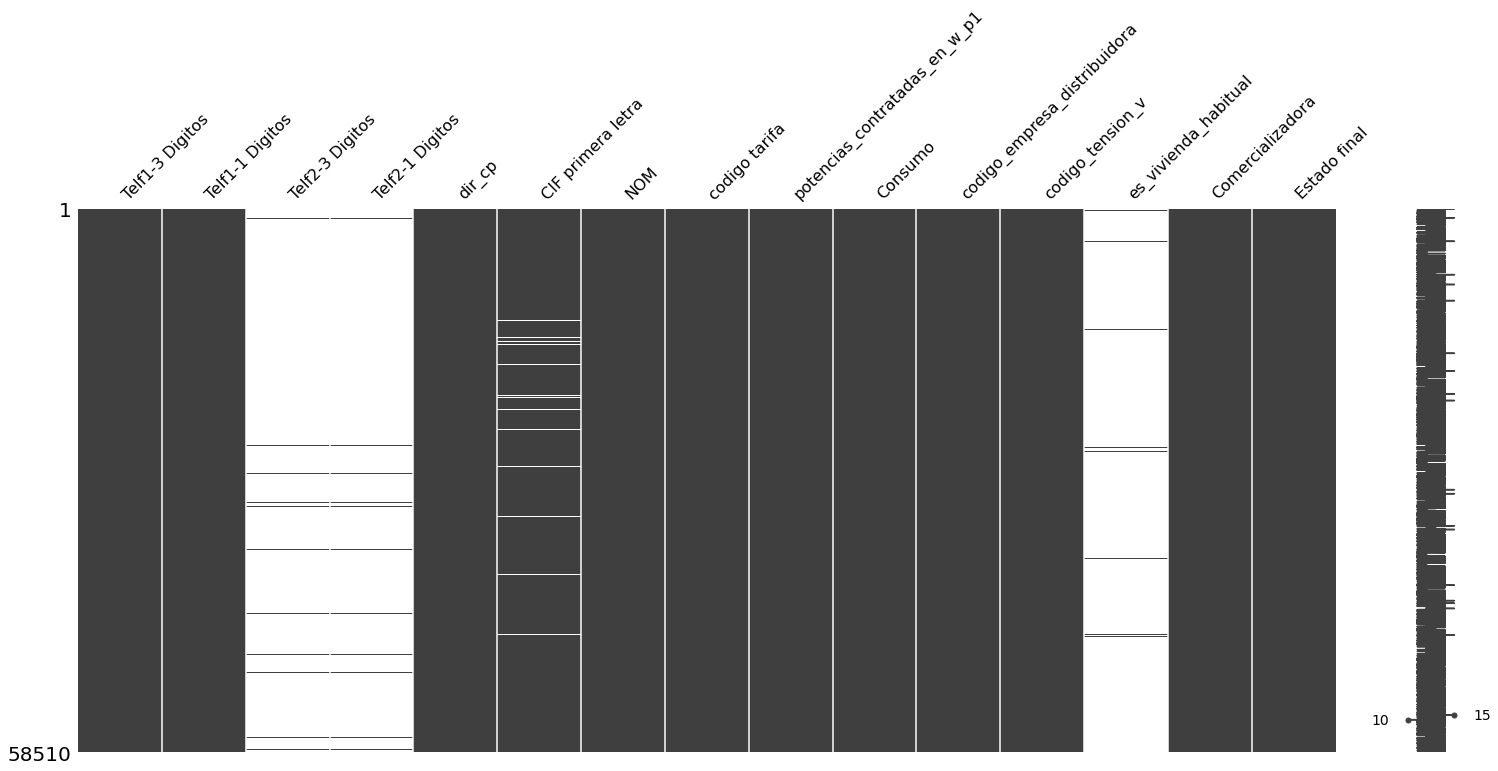

In [4]:
msno.matrix(df)

El Pandas Profile Report nos permite ver rápidamente las características principales del dataset (distribuciones, valores extremos, missing values, etc.). Clicar [aquí](https://rcruzgar.github.io/prediccion_clientes/) para abrirlo.

In [5]:
profile = ProfileReport(df, minimal=True)
profile.to_file("/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/index.html") # Guarda el report en un .html

# **1. Análisis exploratorio**

### El primer paso va a ser un **análisis exploratorio de los datos**, para detectar posibles problemas, como datos que puedan faltar, valores extremos o sesgos. Este paso nos permitirá diseñar la parte de modelización con mucha más información, y por lo tanto de forma más efectiva. Para ello, analizaremos individualmente todas las variables, ya que en este caso tenemos solo 15.

**Variables de teléfono**:

-Telf1-3 Digitos: Tres primeros dígitos del teléfono fijo.

-Telf1-1 Digitos: Primer dígito teléfono fijo.

-Telf2-3 Digitos: Tres primeros dígitos del teléfono móvil. Demasiados *missing values*.

-Telf2-1 Digitos: Primer dígito teléfono móvil. Demasiados *missing values*.

La mayoría de teléfonos fijos empiezan con 937 (un 29.1% de ellos), que es un prefijo muy común en Barcelona. Si el **teléfono fijo** empieza por 6 o 7 es que es un móvil, y si el móvil empieza por 8 o 9 es que es un fijo, por lo que corregiremos donde se diera el caso. En principio, solo nos centraremos en el primer dígito (móvil o fijo) y no trataremos de inferir la relación con la zona del prefijo, ya que ésto lo haremos con el código de la empresa distribuidora.

Contamos el total de cada categoría:

1111 personas con móviles (prefijos 6 y 7) como teléfono fijo (incorrecto):

In [6]:
df['Telf1-1 Digitos'].value_counts()

9    57382
6     1109
8       17
7        2
Name: Telf1-1 Digitos, dtype: int64

10 personas con fijos (prefijos 8 y 9) como teléfono móvil (incorrecto):

In [7]:
df['Telf2-1 Digitos'].value_counts()

6.0    1971
9.0       9
7.0       1
8.0       1
Name: Telf2-1 Digitos, dtype: int64

0 personas con el móvil y el fijo cambiados:

In [8]:
df['Telf1-1 Digitos'][(df['Telf1-1 Digitos'] == 6) & (df['Telf2-1 Digitos'] == 9)].value_counts()

Series([], Name: Telf1-1 Digitos, dtype: int64)

1798 personas con móvil (solo prefijo 6) y fijo (solo prefijo 9):

In [9]:
df['Telf1-1 Digitos'][(df['Telf1-1 Digitos'] == 9) & (df['Telf2-1 Digitos'] == 6)].value_counts()

9    1798
Name: Telf1-1 Digitos, dtype: int64

**Correcciones**:

Donde en el fijo haya un móvil (6 ó 7), pasa esa información a móvil y borra el móvil del fijo:

In [10]:
df.loc[(df['Telf1-1 Digitos'] == 6) | (df['Telf1-1 Digitos'] == 7), 'Telf2-1 Digitos'] = 6
df.loc[(df['Telf1-1 Digitos'] == 6) | (df['Telf1-1 Digitos'] == 7), 'Telf1-1 Digitos'] = np.nan

Donde en el móvil haya un fijo (8 ó 9), pasa esa información a fijo y borra el fijo del móvil:

In [11]:
df.loc[(df['Telf2-1 Digitos'] == 9) | (df['Telf2-1 Digitos'] == 8), 'Telf1-1 Digitos'] = 9
df.loc[(df['Telf2-1 Digitos'] == 9) | (df['Telf2-1 Digitos'] == 8), 'Telf2-1 Digitos'] = np.nan

Vamos a crear una columna con varias categorías en torno a los teléfonos:

1 = Solo fijo.

2 = Solo móvil.

3 = Con fijo y móvil.

In [12]:
# Para simplificar, ponemos todos los fijos con 9 y todos los móviles con 6:
df.loc[df['Telf1-1 Digitos'] == 8, 'Telf1-1 Digitos'] = 9
df.loc[df['Telf2-1 Digitos'] == 7, 'Telf2-1 Digitos'] = 6

In [13]:
def label_phone(row):
  if row['Telf1-1 Digitos'] == 9 and row['Telf2-1 Digitos'] != 6 and row['Telf2-1 Digitos'] != 9:
    return 1
  if row['Telf2-1 Digitos'] == 6 and row['Telf1-1 Digitos'] != 9:
    return 2
  if row['Telf1-1 Digitos'] == 9 and row['Telf2-1 Digitos'] == 6:
    return 3

In [14]:
df['phone'] = df.apply(lambda row: label_phone(row), axis=1)
df['phone'].value_counts()

1    55600
3     1799
2     1111
Name: phone, dtype: int64

Borramos las columnas de teléfono ahora que hemos extraído la información que nos interesa:

In [15]:
df.drop(['Telf1-3 Digitos', 'Telf1-1 Digitos', 'Telf2-3 Digitos', 'Telf2-1 Digitos'], axis=1, inplace=True)

**La primera letra del CIF** en su mayoría es un número, y en menor medida es una letra. También hay personas sin información en el CIF. Esta variable a priori no nos ofrece mucha información para predecir la contratación, por lo que la vamos a descartar.

In [16]:
df.drop(['CIF primera letra'], axis=1, inplace=True)

**Código postal:** La mayoría de personas viven en la misma zona. Hay 363 códigos postales distintos para las personas que al final contratan. Una opción sería clusterizar viendo espacialmente cada código para reducir las categorías de la variable, pero el código de la empresa distribuidora ya nos da una información más general de la zona, como veremos adelante. Por tanto, nos deshacemos del código postal.

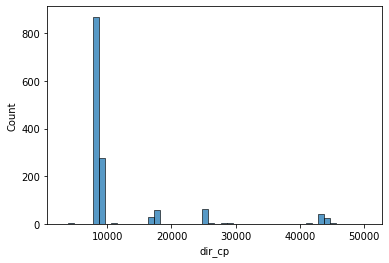

In [17]:
ax = sns.histplot(df['dir_cp'][df['Estado final']==1], bins=50)

In [18]:
df['dir_cp'][df['Estado final']==1].nunique()

363

In [19]:
df.drop(['dir_cp'], axis=1, inplace=True)

**Código tarifa**: No existe la tarifa 2, y solo se da un caso de tarifa 11, por lo que podría ser un error. La gran mayoría tiene la tarifa 1 (79.3 %), seguida por la tarifa 4 (18.5%).

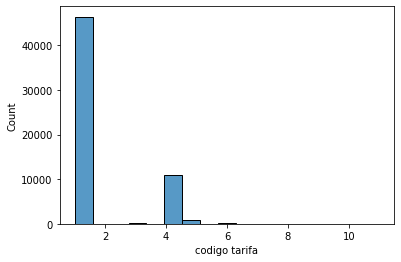

In [20]:
ax = sns.histplot(df['codigo tarifa'])

**Potencia contratada** (W): La gran mayoría se sitúa cerca de los 5 kW. Más de 10 kW seguramente serán empresas. Hay una persona con 200 kW.

In [21]:
df['potencias_contratadas_en_w_p1'].describe()

count     58510.00000
mean       5138.50441
std        2149.90295
min         100.00000
25%        4400.00000
50%        4400.00000
75%        5500.00000
max      200000.00000
Name: potencias_contratadas_en_w_p1, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


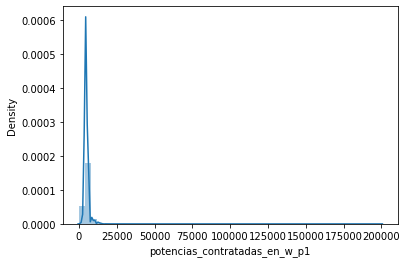

In [22]:
ax = sns.distplot(df['potencias_contratadas_en_w_p1'])

**Consumo anual** (kW h): Tiene algunos valores extremos, como los 495830 kW h anuales de máximo. La media es sobre 3000 kW h. Hay 45 personas sin valores de consumo (*missing values*). Estos 45 valores podrían rellenarse con el consumo medio o mediano, pero como no hay ninguna persona contratada con consumo faltante y como estos valores representan menos de 0.01% del total, borramos esas filas.

In [23]:
df['Consumo'].describe()

count     58465.000000
mean       3002.702968
std        3562.036433
min           0.000000
25%        1580.000000
50%        2442.000000
75%        3705.000000
max      495830.000000
Name: Consumo, dtype: float64

In [24]:
print(df['Consumo'].isnull().sum())
df = df[pd.notnull(df['Consumo'])]

45


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


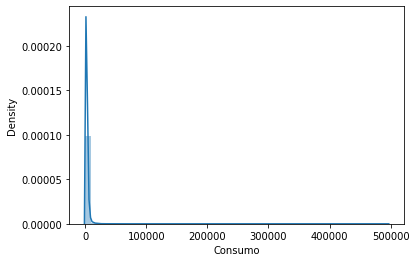

In [25]:
ax = sns.distplot(df['Consumo'])

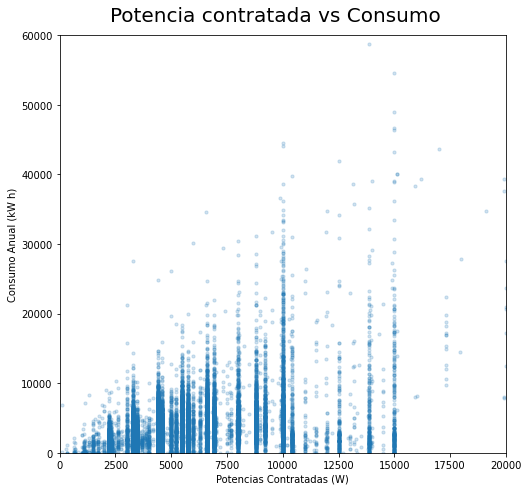

In [26]:
fig1 = plt.figure(figsize=(8,8))
sc = plt.scatter(df['potencias_contratadas_en_w_p1'], df['Consumo'],
                    alpha = 0.2, s = 10)
plt.xlim(0, 20000) # Excluimos los outliers del gráfico
plt.ylim(0, 60000)
plt.xlabel('Potencias Contratadas (W)')
plt.ylabel('Consumo Anual (kW h)')
fig1.suptitle('Potencia contratada vs Consumo', size=20, y=0.9)
plt.subplots_adjust(top=0.85)
plt.show()

**Código empresa distribuidora** (determina la zona): En su mayoría es 31 (99%).

In [27]:
df['codigo_empresa_distribuidora'].value_counts()

31    57872
21      332
22      257
27        4
Name: codigo_empresa_distribuidora, dtype: int64

**Código tensión**: Nivel de tensión del suministro. El 90.4% de los clientes tiene el nivel 2, seguido del nivel 4, con un 4%.

In [28]:
df['codigo_tension_v'].value_counts()

2     52838
4      2346
6      2080
12      500
14      346
1       280
7        25
9        17
8        17
10       11
11        3
27        1
5         1
Name: codigo_tension_v, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


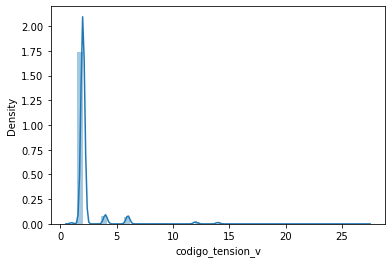

In [29]:
ax = sns.distplot(df['codigo_tension_v'])

**Vivienda habitual**: Sin rellenar para la mayoría de clientes.

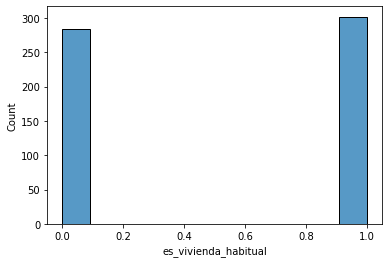

In [30]:
ax = sns.histplot(df['es_vivienda_habitual'])

De los 1395 clientes contratados, 9 especificaron que no es vivienda habitual y 7 que sí. Para el resto no hay información, por lo que vamos a borrar esta variable.

In [31]:
df['es_vivienda_habitual'][df['Estado final'] == 1].value_counts()

0.0    9
1.0    7
Name: es_vivienda_habitual, dtype: int64

In [32]:
df.drop(['es_vivienda_habitual'], axis=1, inplace=True)

**Comercializadora**: Código de la comercializadora anterior.

In [33]:
df['Comercializadora'].value_counts()

91.0      32738
389.0      9449
636.0      7564
927.0      6295
86.0       1539
          ...  
425.0         1
385.0         1
108.0         1
1012.0        1
922.0         1
Name: Comercializadora, Length: 68, dtype: int64

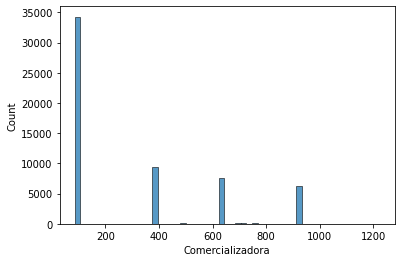

In [34]:
ax = sns.histplot(df['Comercializadora'])

Esta variable tiene varios valores nulos (51, de los cuales 13 son contrataciones). Como muchos modelos presentan problemas con estos valores y ya que la comercializadora es un dato difícilmente inferible del resto de variables, optamos por borrar las filas con valores nulos.

In [35]:
print(df['Comercializadora'].isnull().sum())
df = df[pd.notnull(df['Comercializadora'])]

51


**Estado final**: Esta va ser la variable a predecir, es decir, nuestro *target* o *label*. La muestra está desequilibrada, ya que hay muy pocas contrataciones en comparación con los clientes que no contratan al final. Cuando creemos el modelo, hay que tenerlo en cuenta para dividir en *training* y *test*.

In [36]:
df['Estado final'].value_counts()

0    57032
1     1382
Name: Estado final, dtype: int64

### Ahora vamos a investigar las posibles relaciones entre las variables y el estado final.

Para empezar, hay varias correlaciones positivas interesantes, como la del *estado final* y el *teléfono*.

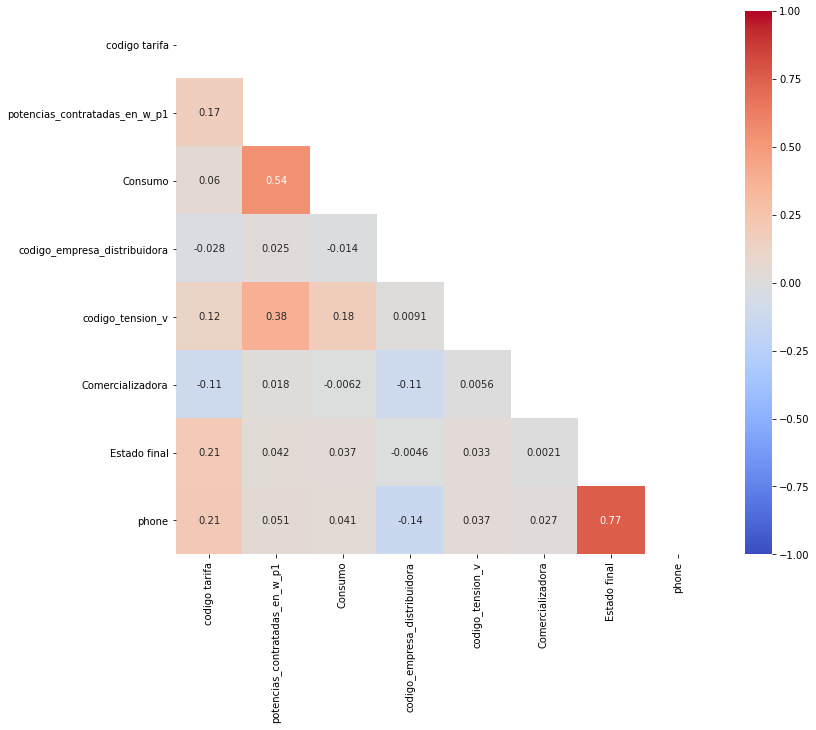

In [37]:
plt.figure(figsize=(12,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), cmap='coolwarm', mask=matrix, annot=True, cbar=True, 
            vmin=-1, vmax=1, center=0)

**¿Para qué categorías hay mayor contratación media?¿Y contrataciones totales?** Con los siguientes gráficos de barras podemos responder a estas preguntas.

Para las variables *potencias contratadas y consumo*, las posibles categorías son tan numerosas que no puede interpretarse fácilmente en un gráfico de barras, por lo que tenemos que reducir las categorías creando grupos o *bins*. Los *bins* los eligiremos en función de los cuantiles de los valores.

In [38]:
potencia_contratados = df['potencias_contratadas_en_w_p1'][df['Estado final']==1]
bins = np.array([0, potencia_contratados.quantile(0.1), potencia_contratados.quantile(0.4),
                 potencia_contratados.quantile(0.6), potencia_contratados.quantile(0.8),
                 potencia_contratados.max()])

df['bins_potencia'] = pd.cut(df['potencias_contratadas_en_w_p1'], bins, labels=['Muy Bajo', 'Bajo', 'Normal', 'Alto', 'Muy Alto'])

In [39]:
consumo_contratados = df['Consumo'][df['Estado final'] == 1]
bins = np.array([0, consumo_contratados.quantile(0.2), consumo_contratados.quantile(0.4),
                 consumo_contratados.quantile(0.6), consumo_contratados.quantile(0.8),
                 consumo_contratados.max()])

df['bins_consumo'] = pd.cut(df['Consumo'], bins, labels=['Muy Bajo', 'Bajo', 'Normal', 'Alto', 'Muy Alto'])

Estos primeros gráficos nos informan de la contratación media por categoría, no del total. Por ejemplo, para el código de tarifa 11 solo se da 1 caso en la muestra total, que justamente se contrata:

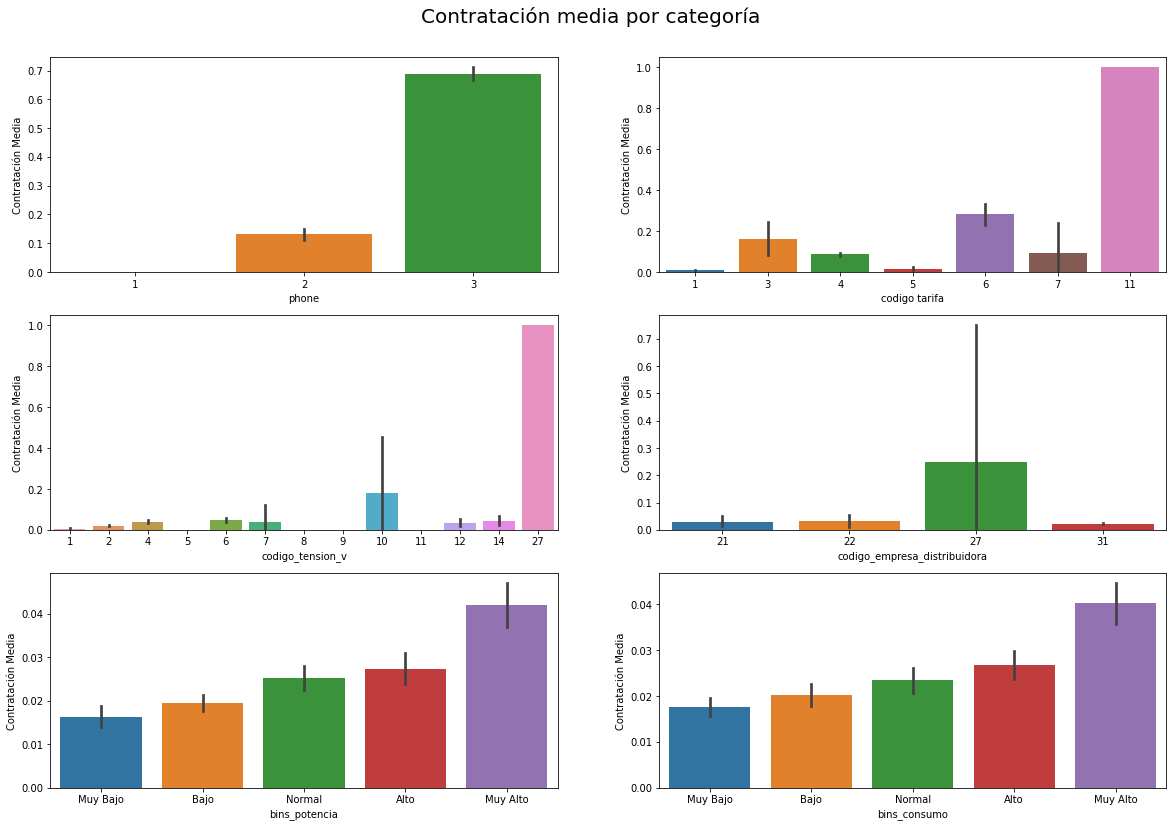

In [40]:
columns_for_barplot = ['phone', 'codigo tarifa', 'codigo_tension_v', 
                       'codigo_empresa_distribuidora', 'bins_potencia',
                       'bins_consumo']
                
fig1 = plt.figure(figsize=(20,14))
index = 0
for var in columns_for_barplot:
    index += 1
    ax = fig1.add_subplot(3, 2, index)
    sns.barplot(x=var, y='Estado final', data=df)
    plt.subplots_adjust(top=0.85)
    ax.set(xlabel=var, ylabel='Contratación Media')
fig1.suptitle('Contratación media por categoría', size=20, y=0.9)
plt.show()

Ahora las contrataciones totales por categorías:

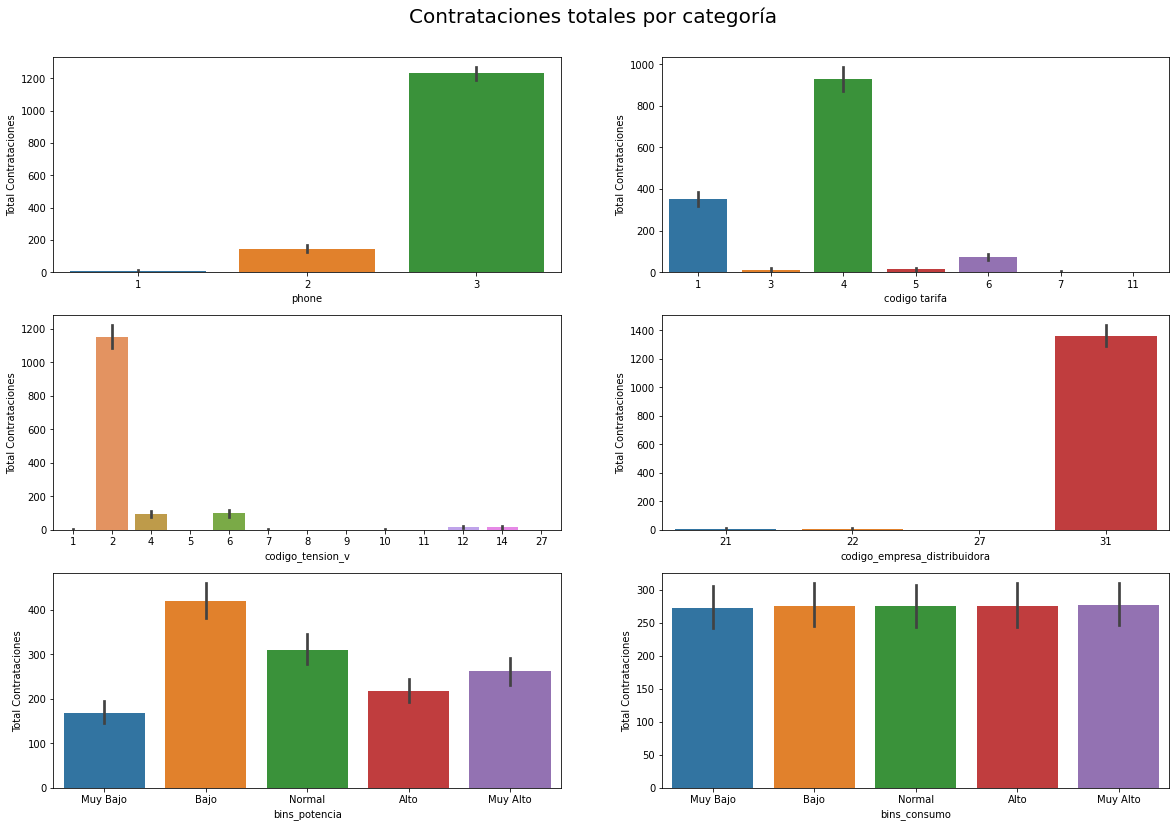

In [41]:
columns_for_barplot = ['phone', 'codigo tarifa', 'codigo_tension_v',
                       'codigo_empresa_distribuidora', 'bins_potencia',
                       'bins_consumo']
                
fig1 = plt.figure(figsize=(20,14))
index = 0
for var in columns_for_barplot:
    index += 1
    ax = fig1.add_subplot(3, 2, index)
    sns.barplot(x=var, y=df['Estado final'], data=df, estimator=sum)
    plt.subplots_adjust(top=0.85)
    ax.set(xlabel=var, ylabel='Total Contrataciones')
fig1.suptitle('Contrataciones totales por categoría', size=20, y=0.9)
plt.show()

La *comercializadora anterior* tiene 25 categorías para los clientes que contratan, por lo que lo visualizamos mejor aparte:

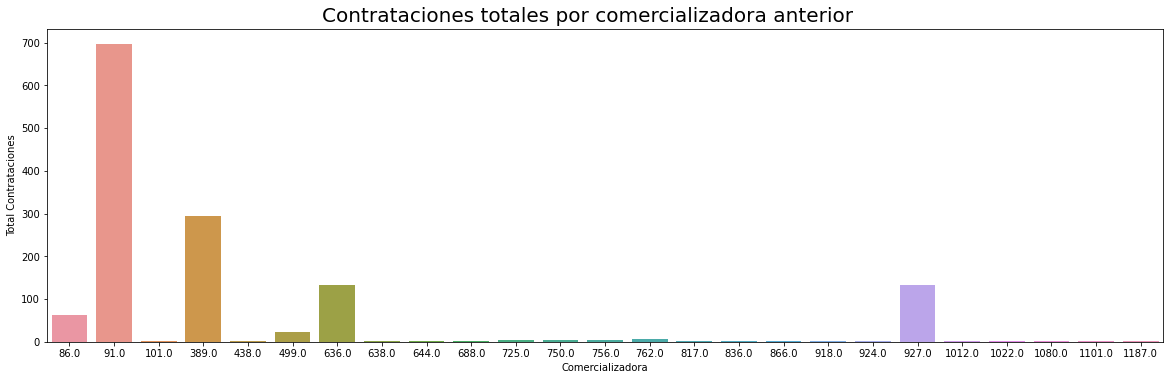

In [42]:
fig1 = plt.figure(figsize=(20,6))
ax = fig1.add_subplot(1, 1, 1)
sns.barplot(x=df['Comercializadora'][df['Estado final']==1], y=df['Estado final'][df['Estado final']==1], data=df, estimator=sum)
plt.subplots_adjust(top=0.85)
ax.set(xlabel='Comercializadora', ylabel='Total Contrataciones')
fig1.suptitle('Contrataciones totales por comercializadora anterior', size=20, y=0.9)
plt.show()

### **Conclusiones de los gráficos de barras**:

- La gente con **teléfono móvil y fijo** (categoría 3) terminan contratando más de media y en absoluto, seguidos por los que solo tienen móvil (categoría 2).
- Aunque de media los **códigos de tarifa** 3 y 6 generan más contrataciones, en total, los que terminan captando más clientes son los códigos 1 y 4.
- Para el **código de tensión** 2 se da el mayor número de contratación absoluto.
- La **empresa distribuidora** 31 muestra las mayores contrataciones totales.
- Cuanto **mayor consumo y mayor potencia contratada**, **más contrataciones medias**. **En términos absolutos, más contrataciones para potencias bajas**, mientras que el consumo no es determinante.
- La **comercializadora anterior** más común es la 91.

Tras hacer la exploración inicial y el procesado de los datos, podemos proceder a construir los modelos.

# **2. Creación del modelo predictivo**

### En esta sección diseñaremos varios modelos de Machine Learning para predecir la contratación de clientes en función de algunas de las variables proporcionadas inicialmente. 

In [50]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from time import time

Elegimos las variables predictoras que formarán parte de los modelos:

In [51]:
features_list = ['codigo tarifa', 'potencias_contratadas_en_w_p1', 'Consumo',
                'codigo_empresa_distribuidora', 'codigo_tension_v', 'Comercializadora',
                'phone']

Como es un dataset muy desequilibrado (pocas contrataciones en comparación con las personas que no contratan al final), hay que aplicar una estratificación al dividir en *training* y *test*, para que la variable objetivo *Estado final* esté igual de representada en ambas particiones. De otra manera podríamos experimentar *oversampling* o *undersampling*. Además, realizaremos un *cross validation* con 6 particiones para seleccionar los modelos con los que continuaremos.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df[features_list], df['Estado final'],
                                                    train_size=0.8, stratify = df['Estado final'],
                                                    random_state=3, shuffle=True)

Tenemos que escalar los datos, ya que vamos a elegir ciertos algoritmos que lo requieren, como SVM. Otros, como los Random Forests, no lo necesitan, pero el resultado sería el mismo. Como hemos detectado algunos *outliers* en el consumo y la potencia, el escalado más conveniente será *RobustScaler*, que a diferencia de otros escalados que usan la media, éste usa la mediana.

In [53]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
kfold = StratifiedKFold(n_splits=6, random_state=3, shuffle=True)

Inicializamos múltiples algoritmos, ya que no hay un modelo que funcione mejor para todas las situaciones. Así que hay que probar cuál da los mejores resultados.

In [55]:
random_state = 3
model_list = []

# Ensemble Methods
model_list.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
model_list.append(ExtraTreesClassifier(random_state=random_state))
model_list.append(GradientBoostingClassifier(random_state=random_state))
model_list.append(RandomForestClassifier(random_state=random_state))

# GLM
model_list.append(LogisticRegression(random_state = random_state))

# Naives Bayes
model_list.append(GaussianNB())

# Nearest Neighbor
model_list.append(KNeighborsClassifier())

# SVM
model_list.append(SVC(random_state=random_state))

# xgboost
model_list.append(XGBClassifier())

In [57]:
t0 = time()
cv_results = []
for model in model_list :
    cv_results.append(cross_val_score(model, X_train_scaled, y=y_train,
                                      scoring='f1', cv=kfold, n_jobs=4))

print('Tiempo total transcurrido: ', '%.3f'%(time() - t0) , 's')

Tiempo total transcurrido:  35.712 s


Evaluamos los modelos con el F1-Score. Esta métrica es más adecuada que otras como la precisión, ya que la muestra está desequilibrada.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


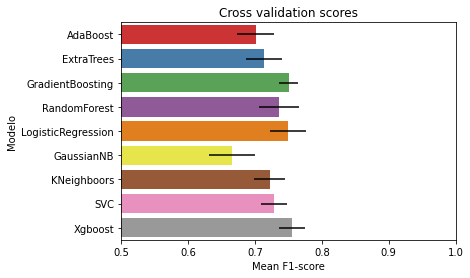

In [58]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std,
                       'Modelo':['AdaBoost', 'ExtraTrees', 'GradientBoosting',
                       'RandomForest', 'LogisticRegression', 'GaussianNB',
                       'KNeighboors', 'SVC', 'Xgboost']})

g = sns.barplot('CrossValMeans', 'Modelo', data=cv_res, palette='Set1',
                 orient='h', **{'xerr':cv_std})
plt.xlim(0.5, 1)
g.set_xlabel('Mean F1-score')
g = g.set_title('Cross validation scores')

Todos los modelos (excepto GaussianNB) tienen un *F1-score* medio similar. Elegiremos RandomForest (porque es sencillo de entender y de tunear), LogisticRegression y Xgboost (porque dan los mejores *F1-scores*).

### **Hyperparameter tuning**

Usamos *Search grid* para elegir los parámetros más óptimos para cada algoritmo:

In [59]:
rf = RandomForestClassifier()
lr = LogisticRegression()
xgboost = XGBClassifier()

# Random Forests:
grid_search_rf = {'max_depth': [4, 6, 8],
                  'max_features': [2, 3, 4, 5],
                  'min_samples_split': [2, 3],
                  'min_samples_leaf': [1, 3],
                  'criterion': ['gini'],
                  'bootstrap': [False],
                  'n_estimators' :[100, 150, 200],
                  'random_state': [3]}

# Logistic Regression:
grid_search_lr = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'penalty': ['l2'],
                  'C': [100, 10, 1.0, 0.1, 0.01],
                  'random_state': [3]}

# Xgboost:
grid_search_xg = {'n_estimators': [50, 100, 150, 200],
                  'max_depth': [2, 4, 6, 8],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                  'random_state': [3]}

rf_gs = GridSearchCV(rf, param_grid = grid_search_rf, cv=kfold, scoring='f1',
                     n_jobs= -1, verbose = 1)

lr_gs = GridSearchCV(lr, param_grid = grid_search_lr, cv=kfold, scoring='f1',
                     n_jobs= -1, verbose = 1)

xg_gs = GridSearchCV(xgboost, param_grid = grid_search_xg, cv=kfold, scoring='f1',
                     n_jobs= -1, verbose = 1)

**Random Forests:**

In [60]:
rf_gs.fit(X_train_scaled, y_train)

Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 18.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=3, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              random_state=None, verbose=0,
                                              warm_start=False),
   

**Logistic Regression:**

In [61]:
lr_gs.fit(X_train_scaled, y_train)

Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=3, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'random_state': [3],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

**XgBoost:**

In [73]:
xg_gs.fit(X_train_scaled, y_train)

Fitting 6 folds for each of 96 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  8.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=3, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logi...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'max_dep

La mejor combinación de parámetros para cada modelo es:

In [74]:
print('Random Forests:')
print(rf_gs.best_params_)

print('Logistic Regression:')
print(lr_gs.best_params_)

print('XgBoost:')
print(xg_gs.best_params_)

Random Forests:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 3}
Logistic Regression:
{'C': 0.1, 'penalty': 'l2', 'random_state': 3, 'solver': 'liblinear'}
XgBoost:
{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'random_state': 3}


Ahora vamos a evaluar los 3 modelos. Lo primero, el F1-Score para el training set (cuanto más próximo a 1, mejor):

In [75]:
print('Random Forests F1-Score (training): {:.3f}'
     .format(rf_gs.best_score_))
print('Logistic Regression F1-Score (training): {:.3f}'
     .format(lr_gs.best_score_))
print('XgBoost F1-Score (training): {:.3f}'
     .format(xg_gs.best_score_))

Random Forests F1-Score (training): 0.772
Logistic Regression F1-Score (training): 0.767
XgBoost F1-Score (training): 0.771


In [76]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Función para dibujar las training y cross-validation learning curves"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score (R2)')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='b')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label= 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='b',
             label= 'Cross-validation score')
    
    plt.legend(loc='best')
    return plt

Las curvas de aprendizaje no muestran diferencias muy significativas, ya que los rangos de *score* entre las que se mueven son muy pequeñas. Para los tres algoritmos, el *score* decrece ligeramente con muestras más grandes, siendo quizás algo más consistente para el Logistic Regression.

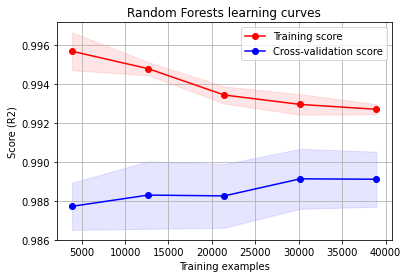

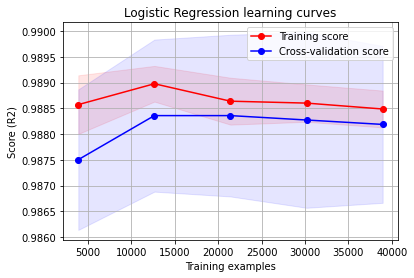

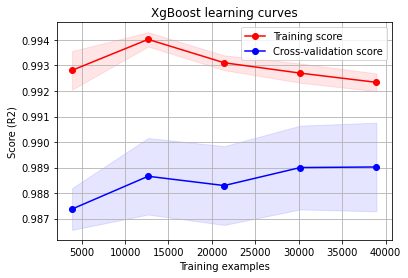

In [77]:
mod_to_plot = ['rf', 'lr', 'xgboost']
info_models = {'lr': ['Logistic Regression', lr_gs], 'rf': ['Random Forests', rf_gs],
               'xgboost': ['XgBoost', xg_gs]}

for mod in mod_to_plot:
  g = plot_learning_curve(info_models[mod][1].best_estimator_,
                          '{0} learning curves'.format(info_models[mod][0]), 
                          X_train_scaled, y_train, cv=kfold)

Elegimos la mejor combinación de parámetros para cada modelo:

In [78]:
rf_best = rf_gs.best_estimator_
lr_best = lr_gs.best_estimator_
xg_best = xg_gs.best_estimator_

Para los dos modelos basados en árboles de decisión, podemos visualizar la importancia de las variables para predecir el estado final.


**Random Forests:**

In [79]:
importances_rf = rf_best.feature_importances_
indices_rf = np.argsort(importances_rf)

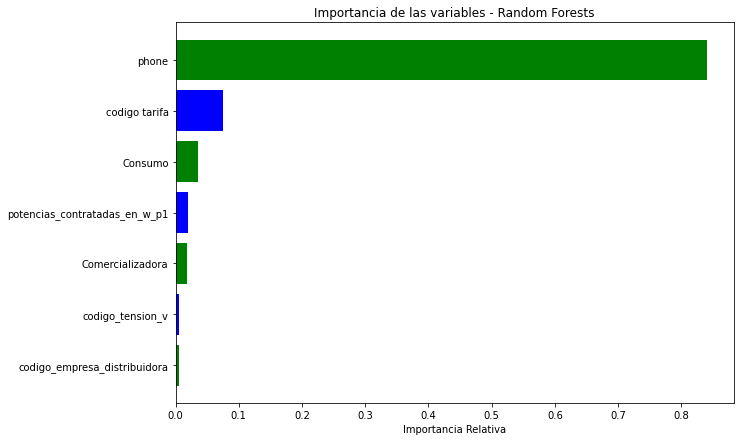

In [80]:
plt.figure(figsize=(10,7))
plt.title('Importancia de las variables - Random Forests')
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color=['g','b'], align='center')
plt.yticks(range(len(indices_rf)), [features_list[i] for i in indices_rf])
plt.xlabel('Importancia Relativa')
plt.show()

**XgBoost:**

In [81]:
importances_xg = xg_best.feature_importances_
indices_xg = np.argsort(importances_xg)

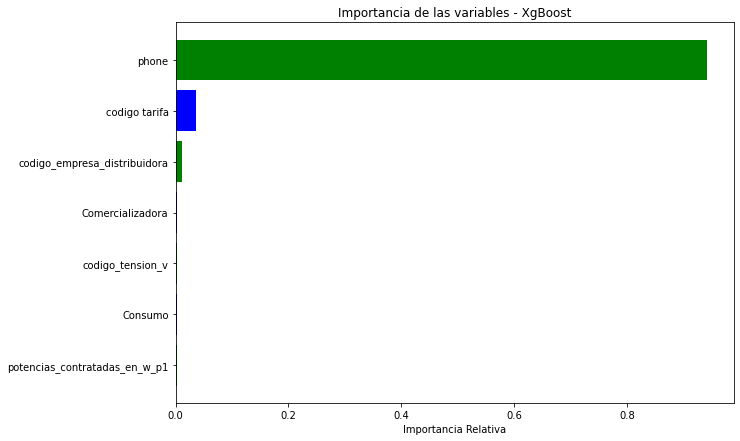

In [82]:
plt.figure(figsize=(10,7))
plt.title('Importancia de las variables - XgBoost')
plt.barh(range(len(indices_xg)), importances_xg[indices_xg], color=['g','b'], align='center')
plt.yticks(range(len(indices_xg)), [features_list[i] for i in indices_xg])
plt.xlabel('Importancia Relativa')
plt.show()

Como vemos, tanto para el Random Forests como para el XgBoost, la variable más importante es el teléfono (si tienen móvil, fijo o ambos), seguido por el código de tarifa. Esta información podría usarse para establecer un límite de importancia para diseñar un modelo con menos variables.

Ahora validamos haciendo las predicciones en datos del test:

In [83]:
rf_test_pred = rf_best.predict(X_test_scaled)
lr_test_pred = lr_best.predict(X_test_scaled)
xg_test_pred = xg_best.predict(X_test_scaled)

Comprobamos el ***Classification report*** (con las principales métricas de evaluación de la predicción) para cada modelo en el *test set*:

In [84]:
mod_to_plot = ['rf', 'lr', 'xgboost']
pred_models = {'lr': ['Logistic Regression', lr_test_pred],
               'rf': ['Random Forests', rf_test_pred],
               'xgboost': ['XgBoost', xg_test_pred]}

for mod in mod_to_plot:
  cl_report = classification_report(y_test, pred_models[mod][1], labels=[1, 0]) 
  print(pred_models[mod][0], '\n', cl_report, '\n', '='*55)

Random Forests 
               precision    recall  f1-score   support

           1       0.73      0.71      0.72       276
           0       0.99      0.99      0.99     11407

    accuracy                           0.99     11683
   macro avg       0.86      0.85      0.86     11683
weighted avg       0.99      0.99      0.99     11683
 
Logistic Regression 
               precision    recall  f1-score   support

           1       0.73      0.80      0.76       276
           0       1.00      0.99      0.99     11407

    accuracy                           0.99     11683
   macro avg       0.86      0.90      0.88     11683
weighted avg       0.99      0.99      0.99     11683
 
XgBoost 
               precision    recall  f1-score   support

           1       0.75      0.70      0.73       276
           0       0.99      0.99      0.99     11407

    accuracy                           0.99     11683
   macro avg       0.87      0.85      0.86     11683
weighted avg       0.99

**Matrices de confusión**: Permiten visualmente evaluar el desempeño de cada modelo para predecir la clase objetivo.

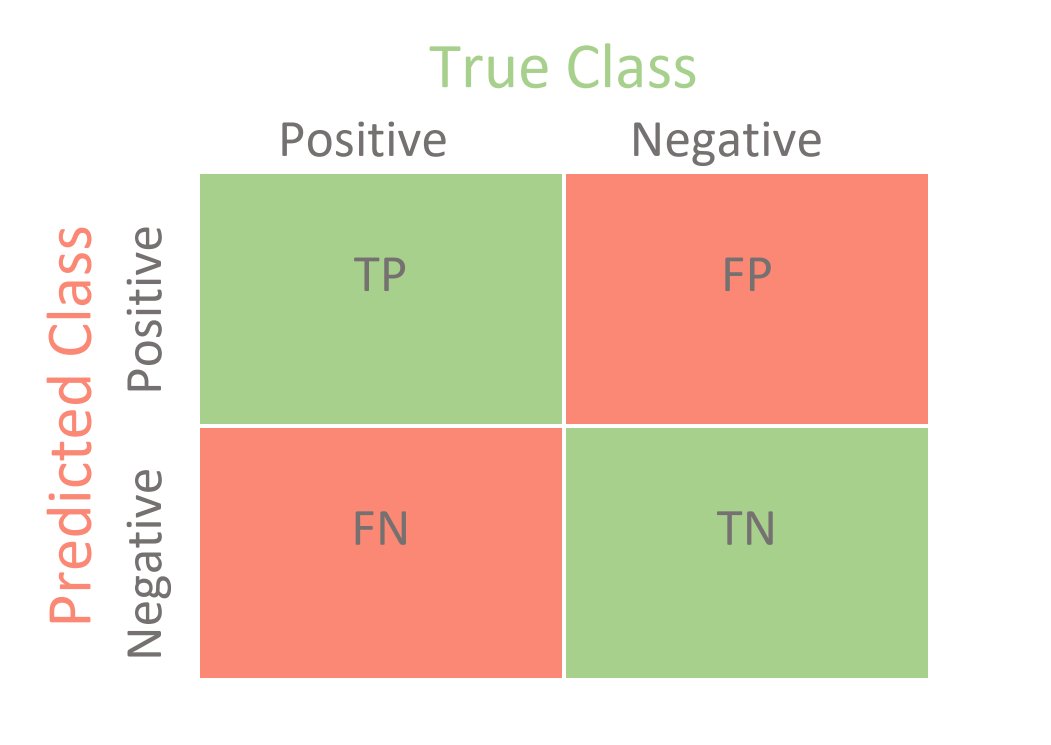

In [85]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/confusion_matrix.png',
      width = 300, height = 300)

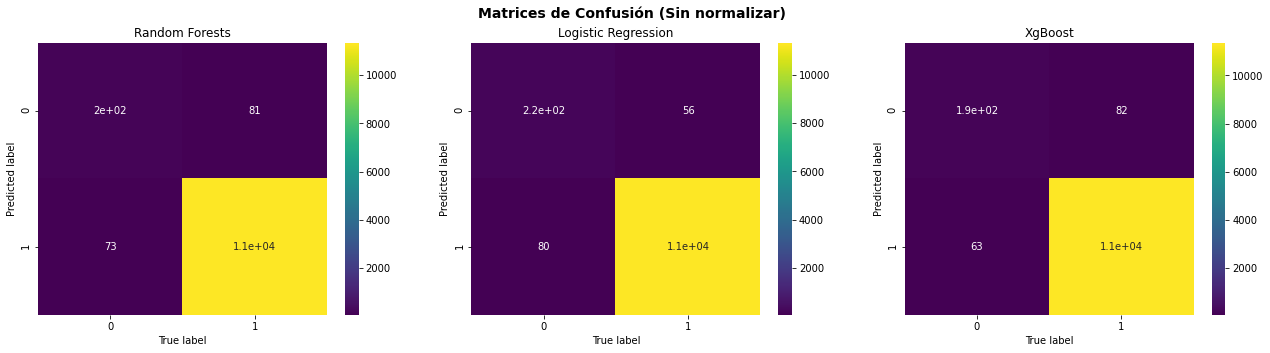

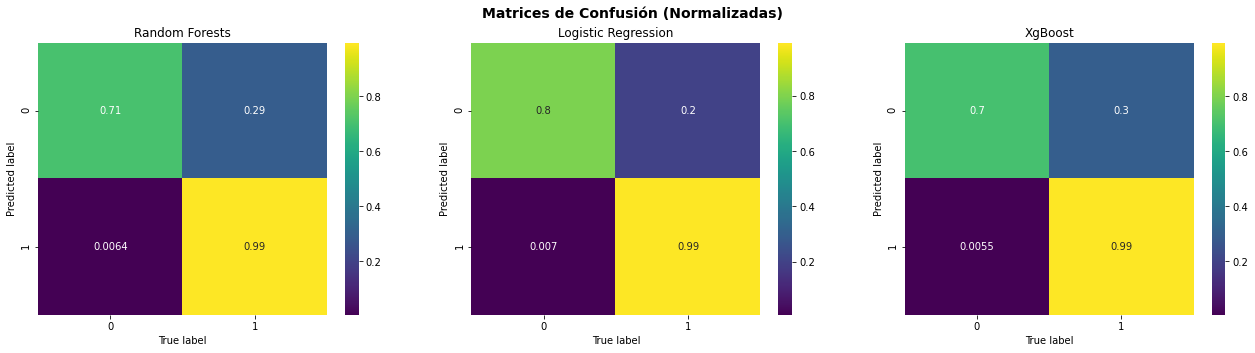

In [86]:
fig1 = plt.figure(figsize=(22, 5))
fig1.suptitle('Matrices de Confusión (Sin normalizar)', fontsize=14, fontweight='bold')

i = 0
for mod in mod_to_plot:
    cm = confusion_matrix(y_test, pred_models[mod][1], labels=[1, 0])
    ax = fig1.add_subplot(1, 3, 1 + i)
    plt.title(pred_models[mod][0])
    im = sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    i = i + 1
plt.show()

fig1 = plt.figure(figsize=(22, 5))
fig1.suptitle('Matrices de Confusión (Normalizadas)', fontsize=14, fontweight='bold')

i = 0
for mod in mod_to_plot:
    cm = confusion_matrix(y_test, pred_models[mod][1], labels=[1, 0], normalize = 'true')
    ax = fig1.add_subplot(1, 3, 1 + i)
    plt.title(pred_models[mod][0])
    im = sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    i = i + 1
plt.show()

Con las matrices de confusión corraboramos lo que se puede ver en el *classification report*: El **Logistic Regression** tiene un mayor F1-Score, lo que se traduce en más predicciones correctas de las contrataciones (2.2e+02) y en menos falsos positivos (56). Este último punto es especialmente importante, ya que según las predicciones del modelo se dedicarán más recursos y tiempo de la empresa a intentar conseguir que esos clientes contraten los servicios ofrecidos.

**ROC Curve**: Tanto las Curvas ROC como los *Area Under Curve* (AUC) son tan similares que no ofrecen información útil.

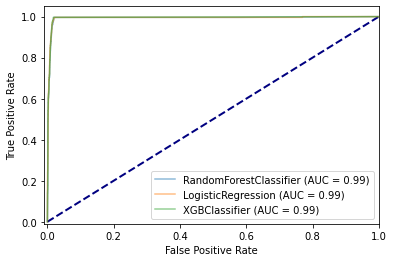

In [87]:
rf_disp = plot_roc_curve(rf_best, X_test_scaled, y_test, alpha=0.5)
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
lr_disp = plot_roc_curve(lr_best, X_test_scaled, y_test, ax=ax, alpha=0.5)
xg_disp = plot_roc_curve(xg_best, X_test_scaled, y_test, ax=ax, alpha=0.5)
plt.show()

Tras la evaluación de los modelos, el más idóneo para predecir si un cliente potencial terminará contratando los servicios es el **Logistic Regression**. Las posibles mejoras de los modelos incluirían:

- Tuning con Feature Selection. Más variables no significa mejor modelo, sino que a menudo seleccionando las variables predictoras adecuadas se puede obtener un modelo que generalice mejor.

- Search Grid más exhaustivo.

- Probar más algoritmos. 

- Eliminar previamente los *outliers* de la muestra. Igualmente, probar con otros métodos de escalado.

- Se podrían combinar los modelos mediante un *VotingClassifier*, donde se tengan en cuenta las predicciones de todos los modelos.

Por último, guardamos los modelos entrenados, por si queremos reutilizarlos:

In [ ]:
from joblib import dump
dump(rf_best, '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/random_forests.joblib')
dump(lr_best, '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/logistic_regression.joblib') 
dump(xg_best, '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/xgboost.joblib') 



---

